In [ ]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from plot_slices import plot_slices
import os
import pydicom

## MAGNITUDE
# Replace this with the path to the folder containing the .IMA files
folder_path = r'C:\DocumentsPC\Research2\2024_10_20RPCAICA\ICASVDNov2024\EPI_CMRR_170BR_0009'

TR = 2
# Get a list of all .IMA files in the folder
ima_files = [f for f in os.listdir(folder_path) if f.endswith('.IMA')]
# Sort the files if needed (by name) - useful if they are sequential slices
ima_files.sort()
# Initialize an empty list to store 2D image data
image_slices = []
# Loop through and read each .IMA file
for ima_file in ima_files:
    file_path = os.path.join(folder_path, ima_file)
    # print(file_path) # make sure images are in the right order.
    # Read the DICOM file
    dicom_data = pydicom.dcmread(file_path)
    
    # Extract pixel data (2D array) and append it to the list
    pixel_array = dicom_data.pixel_array
    image_slices.append(pixel_array)
# Convert the list of 2D slices to a 3D numpy array
img = np.stack(image_slices, axis=-1)

print(f"img (magnitude) saved with shape: {img.shape}")
x, y, ntps = img.shape
img2d = img.reshape(x*y, ntps)
print(f"img (magnitude) by time saved with shape: {img2d.shape}")

print(f"Is 'your_data' a NumPy array? {isinstance(img2d, np.ndarray)}")
print(f"Shape of your_data: {img2d.shape}")
print(f"Type of your_data: {type(img2d)}")

# # check mean image
# boldmin = 0
# boldmax = 1
# print("mean image:")
# plt.imshow(np.mean(img,axis=2), cmap='gray')
# plt.show()




img (magnitude) saved with shape: (704, 704, 170)
img (magnitude) by time saved with shape: (495616, 170)
Is 'your_data' a NumPy array? True
Shape of your_data: (495616, 170)
Type of your_data: <class 'numpy.ndarray'>


In [2]:
# measure task activation
from HRFtask2 import HRFtask2
from FDRBHact import FDRBHact
from GLM import GLM

# create design matrix: for all data, same design matrix

onTime = 20
delay = 4
N_tpt = img2d.shape[1]
ASL = 0 # for running subtraction?
plotTask = 0
task, taskdiff = HRFtask2(onTime, N_tpt, TR, delay, ASL, plotTask)
print(f"Size of matrix task: {task.shape}")
X = np.column_stack((np.ones(task.shape[0]), task.flatten()))
q = 0.05 # adjust threshold for activation, usually 0.05, can decrease to get less voxels so tICA can be run
FWHM = 0
# data needs to be 4D for my FDRBHact function (FIX LATER)
from scipy.ndimage import gaussian_filter
sigma = [1, 1, 0]  # Smoothing applied to the first two dimensions, none on the third
epsilon = 1e-10  # You can adjust this value based on how small the noise should be # doesn't work at 1e-10?
noise = np.random.normal(loc=0, scale=epsilon, size=img.shape) # to stop non-activation 0s to not be active
smoothed_img = gaussian_filter(img + noise, sigma=sigma)

imgplot = np.zeros((x,y,1,N_tpt))
imgplot[:,:,0,:] = np.copy(smoothed_img)
print(imgplot.shape)
print(imgplot.shape)

log10p_orig = FDRBHact(imgplot, FWHM, q, X)
print(log10p_orig.shape)

print(f"Size of matrix log10: {log10p_orig.shape}")
log10p_orig = log10p_orig[:,:,:,1]

# print("activation -log10(p-value):")
# plt.imshow(log10p_orig, cmap='gray')
# plt.show()

perf_run = img
# number of activated voxels:
num_nonzero = np.count_nonzero(log10p_orig)

# print(f"number of activated voxels: {num_nonzero}")
# plt.imshow(np.mean(img,axis=2), cmap='gray')
# plt.show()


Size of matrix task: (170,)
(704, 704, 1, 170)
(704, 704, 1, 170)
(704, 704, 1, 2)
Size of matrix log10: (704, 704, 1, 2)


In [3]:
# CHANGING PRESENTATION OF THE SLICES
# !pip install nilearn nibabel

from nilearn import plotting, image
import nibabel as nib

# plot np.mean(img,axis=2) and log10p_orig

print(img.shape)
# Define the size of each slice and the number of slices per dimension
slice_size = 88
num_slices_per_dim = 704 // slice_size  # This should be 8
num_slices = num_slices_per_dim * num_slices_per_dim  # Total slices (8*8=64)
time_points = img.shape[2]  # This should be 170

# Initialize an empty list to hold the slices across time
all_slices = []

# Loop over each time point
for t in range(time_points):
    # Extract the 704x704 matrix for this time point
    time_slice = img[:, :, t]
    
    # Extract each 88x88 slice from the 704x704 matrix
    slices = []
    for i in range(num_slices_per_dim):
        for j in range(num_slices_per_dim):
            # Extract each 88x88 slice
            slice_88x88 = time_slice[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
            slices.append(slice_88x88)
    
    # Stack slices for this time point and add to the list
    all_slices.append(np.stack(slices, axis=0))

# Convert the list to a 4D NumPy array: (64, 88, 88, 170)
slices_4d = np.stack(all_slices, axis=-1)


print(slices_4d.shape)
fMRImean = np.mean(slices_4d,axis=3)
print(fMRImean.shape)

slicecheck = 45
# plt.imshow(fMRImean[slicecheck,:,:], cmap='gray') # check images
# plt.show()

# Loop over each time point
    # Extract the 704x704 matrix for this time point
print(log10p_orig.shape)

# Initialize an empty array to hold the 3D data with shape (64, 88, 88)
slices_3d = np.zeros((num_slices_per_dim**2, slice_size, slice_size))
slice_index = 0
for i in range(num_slices_per_dim): # Loop to extract each 88x88 slice
    for j in range(num_slices_per_dim):
        # Extract each 88x88 slice
        slices_3d[slice_index, :, :] = np.squeeze(log10p_orig[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size])
        slice_index += 1
log10p_orig3d = np.copy(slices_3d)


# plt.imshow(log10p_orig3d[slicecheck,:,:], cmap='gray',vmin = 0, vmax = 8) # check images
# plt.show()

print(f"max of log10: {np.max(log10p_orig3d)}")





(704, 704, 170)
(64, 88, 88, 170)
(64, 88, 88)
(704, 704, 1)
max of log10: 307.6526555685888


<class 'nibabel.nifti1.Nifti1Image'>
<class 'nibabel.nifti1.Nifti1Image'>


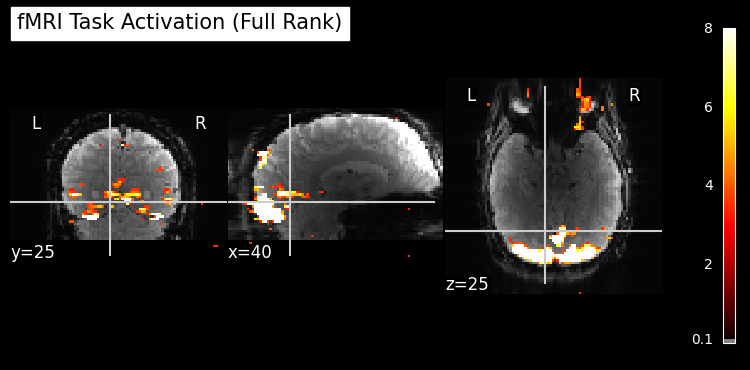

In [4]:
# Plot activation
affine = np.eye(4)

# Convert arrays to NIfTI images
anat_data = np.copy(fMRImean)
anat_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(anat_data, (1, 2, 0)),3),axis=2), affine)

act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_orig3d, (1, 2, 0)),3),axis=2), affine)
print(type(anat_img))
print(type(act_img))

# Plot the activation map overlay
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title='fMRI Task Activation (Full Rank)',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)



shape of S_: (495616, 20)
Original shape: (495616, 20)
ICA components shape: (704, 704, 20)
shape A_: (170, 20)
Shape of correlations: (20,)
Correlations: [-0.17247882 -0.10319592  0.13259145  0.18345178 -0.05224584 -0.03362769
 -0.15311471  0.26723937  0.09899643  0.03783378 -0.79643683  0.08826112
 -0.0816436  -0.06933126 -0.09086393  0.01321926  0.09904218  0.01497606
 -0.1806682   0.11384294]
Component with highest correlation: 10
Correlation value: -0.796436832102284
(170, 20)
(495616, 20)
time course and spatial map of zeroed IC


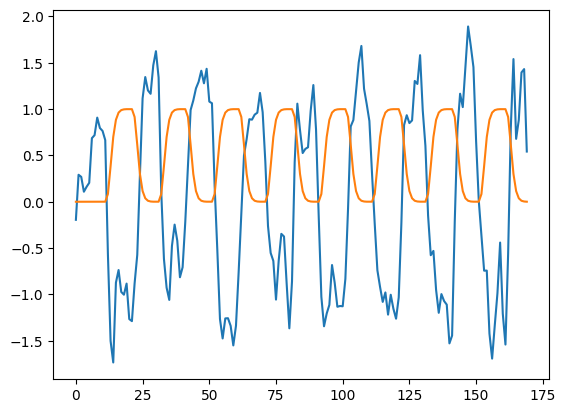

In [5]:
# only working with magnitude data.
# run ICA to extract independent components
from sklearn.decomposition import FastICA

# Reshape the image to 2D
img_2d = img2d
img_2d_mean = np.mean(img_2d, axis=0) # the right mean?

#img_2d_centered = img_2d - img_2d_mean # use this?

# Run ICA
n_components = 20  # Adjust this based on your needs
ica = FastICA(n_components=n_components, random_state=42)
S_ = ica.fit_transform(img_2d)  # 
print(f"shape of S_: {S_.shape}") # S_ now contains the independent components
A_ = ica.mixing_
# To reconstruct the original signal (optional):
reconstructed = S_ @ A_.T
# Reshape the independent components back
ic_4d = S_.reshape((x, y, -1))
# ic_4d now contains the spatial maps of each independent component
print("Original shape:", S_.shape)
print("ICA components shape:", ic_4d.shape)

# # To view individual components:
# for i in range(n_components):
#     component = ic_4d[:,:,:,i]
#     print(f"component: {i+1}")
#     plot_slices(component)
    
def plot_time_course(mixing_matrix):
    """
    Plot the time courses for the mixing matrix.
    """
    plt.figure(figsize=(12, 6))
    for i in range(mixing_matrix.shape[1]):
        plt.plot(mixing_matrix[:, i], label=f'IC {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Time Courses of Independent Components')
    plt.legend()
    plt.grid(True)
    plt.show()


# find the ICs that we want to remove before a PCA for denoising

print(f"shape A_: {A_.shape}")


def correlate_with_columns(vector, matrix):
    """
    Correlate a vector with each column of a matrix.
    :param vector: 1D numpy array
    :param matrix: 2D numpy array
    :return: 1D numpy array of correlation coefficients
    """
    # Ensure the vector and matrix have the same number of rows
    assert vector.shape[0] == matrix.shape[0], "Vector and matrix must have the same number of rows"
    # Calculate the correlation coefficient for each column
    correlations = np.array([np.corrcoef(vector, matrix[:, i])[0, 1] for i in range(matrix.shape[1])])
    return correlations

correlations = correlate_with_columns(task, A_)

print("Shape of correlations:", correlations.shape)
print("Correlations:", correlations)

# Find the index of the component with the highest absolute correlation
max_corr_index = np.argmax(np.abs(correlations))
print(f"Component with highest correlation: {max_corr_index}")
print(f"Correlation value: {correlations[max_corr_index]}")


# recon data without the IC:
S_zerod = np.copy(S_)
S_zerod[:,max_corr_index] = np.zeros_like(S_zerod[:,max_corr_index])
print(A_.shape)
print(S_zerod.shape)

recon_noic = (S_zerod @ A_.T) + img_2d_mean
# adding the mean of each column back in, right?

# plot IC being removed:
print("time course and spatial map of zeroed IC")
TC = (A_[:, max_corr_index] - np.mean(A_[:, max_corr_index],axis=0))/np.std(A_[:, max_corr_index],axis=0)
plt.plot(TC, label=f'IC {max_corr_index+1}')
plt.plot(task, label=f'task')
plt.show()

S_ic = S_[:,max_corr_index].reshape(x, y)
# plt.imshow(S_ic) # to see spatial map has visual cortex activation
# plt.show()



In [6]:

print(f"recon_noic shape: {recon_noic.shape}")
print(f"rank recon_noic: {np.linalg.matrix_rank(recon_noic)}")

# Perform SVD 
U, sigma, Vt = np.linalg.svd(recon_noic, full_matrices=False)
k = 10  # or any rank you want
U_k = U[:, :k]
sigma_k = np.diag(sigma[:k])  # Convert the top k singular values into a diagonal matrix
Vt_k = Vt[:k, :]
L = np.dot(U_k, np.dot(sigma_k, Vt_k))
# Now L is the low-rank approximation of rank k



recon_noic shape: (495616, 170)
rank recon_noic: 20


In [7]:

# use svd on L to get the vectors , add column to U and V with 1 in Sigma to add the IC back in.
def extend_svd(L, S_, A_, i):
    print(f"using index {i}")     
    U, s, Vt = np.linalg.svd(L, full_matrices=False) # Perform SVD on L
    S = np.diag(s)     # Convert s to a diagonal matrix
    s_i = S_[:, i].reshape(-1, 1)     # Get the ith column of S_ and A_
    a_i = A_[:, i].reshape(-1, 1)
    V_extended = np.hstack((Vt.T, a_i))     # Extend V (RSVs) with s_i    
    U_extended = np.hstack((U, s_i))     # Extend U (LSVs) with a_i
    S_extended = np.zeros((S.shape[0] + 1, S.shape[1] + 1))     # Extend S (singular values) with 1
    S_extended[:S.shape[0], :S.shape[1]] = S
    S_extended[-1, -1] = 1
    return U_extended, S_extended, V_extended

U_new, S_new, V_new = extend_svd(L, S_, A_, max_corr_index)
print(f"shape of S_new: {S_new.shape}")
print(f"shape of U_new: {U_new.shape}")
print(f"shape of V_new: {V_new.shape}")

singular_values = np.diag(S_new[:-1,:-1])
# print(singular_values.shape)
# print("Singular values:")
# for i, value in enumerate(singular_values, 1):
#     print(f"{i}: {value}")

# # remove singular values and keep the last one

rank = np.linalg.matrix_rank(L)
print(f"rank of L {rank}")
S_aug = S_new[:rank,:rank]
U_aug = U_new[:,:rank]
V_aug = V_new[:,:rank]
S_aug[-1:,-1] = S_new[-1:,-1]
U_aug[:,-1] = U_new[:,-1]
V_aug[:,-1] = V_new[:,-1]
print(f"shape of S_aug: {S_aug.shape}")
print(f"shape of U_aug: {U_aug.shape}")
print(f"shape of V_aug: {V_aug.shape}")
# cuts off last RSV this way

img_denoised = U_aug @ S_aug @ V_aug.T

ic_3d = U_aug.reshape((*img.shape[:2], -1))
# for i in range(2): # to plot components
#     component = ic_3d[:,:,i]
#     print(f"component: {i+1}")
#     plt.imshow(component)
#     plt.show()
#     #plot_slices(component)
# component = ic_3d[:,:,-1]
# print(f"component: ica added back in")
# plt.imshow(component)
# plt.show()

# # ica spatial map confirmation
# ic_4d = S_.reshape((*img_unsub.shape[:3], -1))
# component = ic_4d[:,:,:,4]
# print(f"component: ica")
# plot_slices(component)
# img_denoised has the image to compare to



using index 10
shape of S_new: (171, 171)
shape of U_new: (495616, 171)
shape of V_new: (170, 171)
rank of L 10
shape of S_aug: (10, 10)
shape of U_aug: (495616, 10)
shape of V_aug: (170, 10)


In [8]:

U, Sigma, Vt = np.linalg.svd(img2d, full_matrices=False)
#k = 7  # or any rank you want

U_k = U[:, :k]
sigma_k = np.diag(Sigma[:k])  # Convert the top k singular values into a diagonal matrix
Vt_k = Vt[:k, :]
L2 = np.dot(U_k, np.dot(sigma_k, Vt_k)) # low-rank approximation of rank k

rank = np.linalg.matrix_rank(L2)
print(f"rank of L2 (w/o IC removed): {rank}")

# S2 = S2.reshape(*img.shape[:2],-1)
# print("Average of the sparse matrix thru time:")
# plt.imshow(np.mean(S2, axis=2))
# plt.show()


rank of L2 (w/o IC removed): 10


C:\Users\march\AppData\Local\Temp\ipykernel_37232\3293574317.py:9: RuntimeWarning: invalid value encountered in divide
  return np.mean(perfusion, axis=2) / np.std(perfusion, axis=2)


Component with highest correlation: 10
Correlation value: 0.48688463752109457


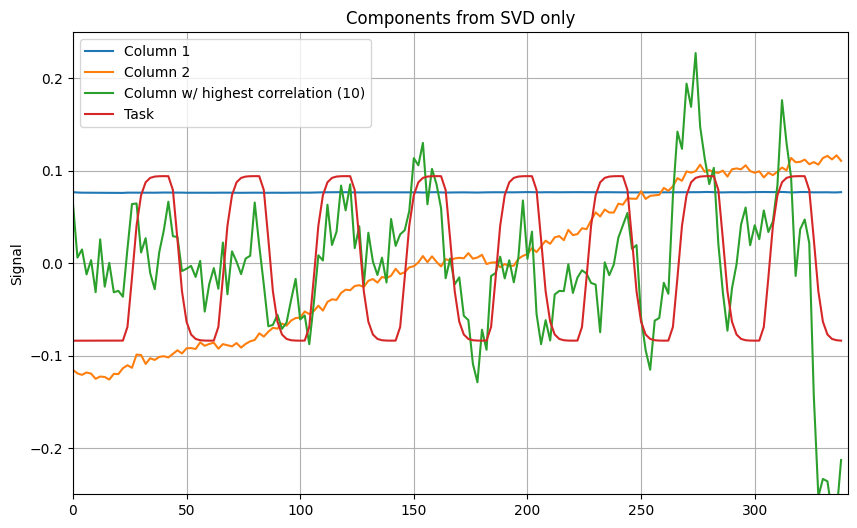

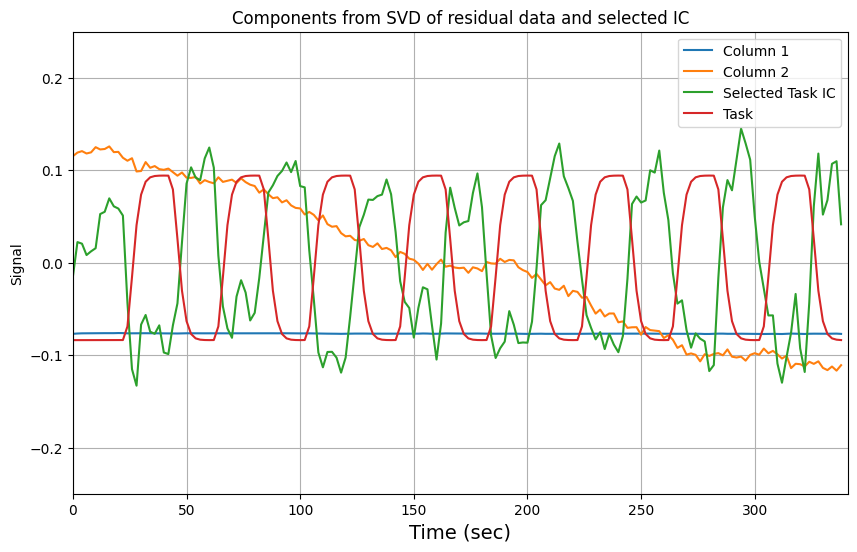

In [9]:

# tSNR comparison
##########################################################################
# ICA-SVD

bold = img_denoised.reshape((*img.shape[:2], -1))

def tSNR_BOLD(perfusion): 
    """Calculate temporal Signal-to-Noise Ratio (tSNR) of perfusion across time (may be used for BOLD)."""
    return np.mean(perfusion, axis=2) / np.std(perfusion, axis=2)

tSNR = tSNR_BOLD(bold)
tSNRmin = 0
tSNRmax = 200
# print("tSNR icasvd:") # if want to compare tSNR
# print(f"tSNR shape: {tSNR.shape}")
# plt.imshow(tSNR, vmin = tSNRmin, vmax = tSNRmax, cmap='gray')
# plt.show()

# SVD only
boldrpca = L2.reshape((*img.shape[:2], -1))

tSNR = tSNR_BOLD(boldrpca)
# print("tSNR svd:")
# print(f"tSNR shape: {tSNR.shape}")
# plt.imshow(tSNR, vmin = tSNRmin, vmax = tSNRmax, cmap='gray')
# plt.show()

# plot SVD time courses:
UL2, SL2, VtL2 = np.linalg.svd(L2, full_matrices=False)

plt.figure(figsize=(10, 6))
num_columns = 3
#ind = np.arange(VtL2.shape[0])
ind = np.arange(VtL2.shape[0])*TR

xmin, xmax = 0, 341
ymin, ymax = -0.25, 0.25

for i in range(num_columns-1):
    plt.plot(ind, VtL2[i, :].T, label=f'Column {i+1}')
#plt.plot(ind, VtL2[-1, :].T, label=f'Last Column')
task = (task - np.mean(task))/np.std(task)

def normalize(v): # https://stackoverflow.com/questions/21030391/how-to-normalize-a-numpy-array-to-a-unit-vector
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

correlationssvd = correlate_with_columns(task, VtL2.T)
max_corr_indexsvd = np.argmax(np.abs(correlationssvd))
print(f"Component with highest correlation: {max_corr_indexsvd+1}")
print(f"Correlation value: {correlationssvd[max_corr_indexsvd]}")

plt.plot(ind, VtL2[max_corr_indexsvd,:].T, label=f'Column w/ highest correlation ({max_corr_indexsvd+1})')
plt.plot(ind, normalize(task), label=f'Task')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

#plt.xlabel('Time (sec)')
plt.ylabel('Signal')
plt.title('Components from SVD only')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
num_columns = 3
#ind = np.arange(V_aug.shape[0])
ind = np.arange(V_aug.shape[0])*TR

for i in range(num_columns-1):
    plt.plot(ind, V_aug[:, i], label=f'Column {i+1}')

def normalize(v): # https://stackoverflow.com/questions/21030391/how-to-normalize-a-numpy-array-to-a-unit-vector
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

last = V_aug[:, -1]
last = (last - np.mean(last))/np.std(last)
last = normalize(last)

plt.plot(ind, last, label=f'Selected Task IC')
plt.plot(ind, normalize(task), label=f'Task')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Signal')
plt.title('Components from SVD of residual data and selected IC')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
# Test activation:
# ICASVD
# MAY WANT TO USE GAUSSIAN SMOOTHING HERE ON IMG, FWHM DOESN'T WORK RIGHT HERE, SO 
# SET IT = 0 AND SMOOTH BEFORE FDRBH CALCULATION.
from scipy.ndimage import gaussian_filter
sigma = [1, 1, 0]  # Smoothing applied to the first two dimensions, none on the third
smoothed_fmri = gaussian_filter(bold + noise, sigma=sigma)

print(f"{x} {y} {1} {N_tpt}")
imgplot = np.zeros((x,y,1,N_tpt))
#imgplot[:,:,0,:] = np.copy(bold)
imgplot[:,:,0,:] = np.copy(smoothed_fmri)
print(imgplot.shape)
log10p_orig = FDRBHact(imgplot, FWHM, q, X)
print(f"Size of matrix log10: {log10p_orig.shape}")
log10p_origsvdica = log10p_orig[:,:,:,1]
print("activation -log10(p-value) SVDICA:")
# plt.imshow(log10p_origsvdica, cmap='gray')
# plt.show()
# number of activated voxels: Not working?
# num_nonzero = np.count_nonzero(log10p_origsvdica)
# print(f"number of activated voxels ICASVD: {num_nonzero}")
print(f"log10p_orig: {log10p_orig.shape}")


print(f"rank ICASVD: {np.linalg.matrix_rank(img_denoised)}")

###########
smoothed_fmrirpca = gaussian_filter(boldrpca + noise, sigma=sigma)

imgplot = np.zeros((x,y,1,N_tpt))
#imgplot[:,:,0,:] = np.copy(boldrpca)
imgplot[:,:,0,:] = np.copy(smoothed_fmrirpca)

print(imgplot.shape)
# MAY WANT TO USE GAUSSIAN SMOOTHING HERE ON IMG, FWHM DOESN'T WORK RIGHT HERE, SO 
# SET IT = 0 AND SMOOTH BEFORE FDRBH CALCULATION.

log10p_orig = FDRBHact(imgplot, FWHM, q, X)
print(f"Size of matrix log10: {log10p_orig.shape}")
log10p_origsvd = log10p_orig[:,:,:,1]
print("activation -log10(p-value) SVD only:")
# plt.imshow(log10p_origsvd, cmap='gray')
# plt.show()
# number of activated voxels: NOT WORKING?
# num_nonzero = np.count_nonzero(log10p_origsvd)   
# print(f"number of activated voxels SVD only: {num_nonzero}")

print(f"log10p_orig: {log10p_orig.shape}")
print(f"rank SVD only: {np.linalg.matrix_rank(L2)}")

# plt.imshow(log10p_origsvdica - log10p_origsvd, cmap='gray')
# plt.show()



704 704 1 170
(704, 704, 1, 170)
Size of matrix log10: (704, 704, 1, 2)
activation -log10(p-value) SVDICA:
log10p_orig: (704, 704, 1, 2)
rank ICASVD: 10
(704, 704, 1, 170)
Size of matrix log10: (704, 704, 1, 2)
activation -log10(p-value) SVD only:
log10p_orig: (704, 704, 1, 2)
rank SVD only: 10


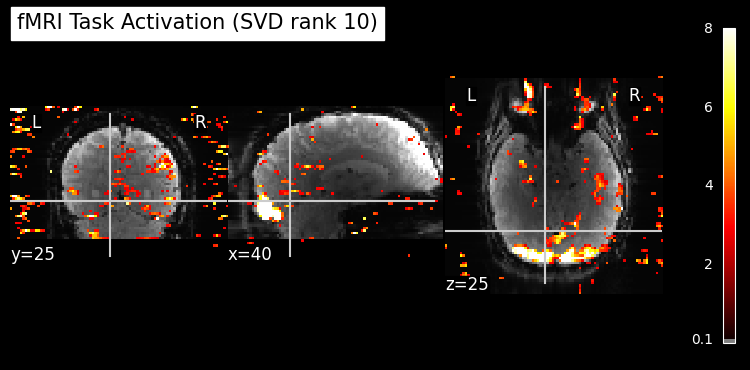

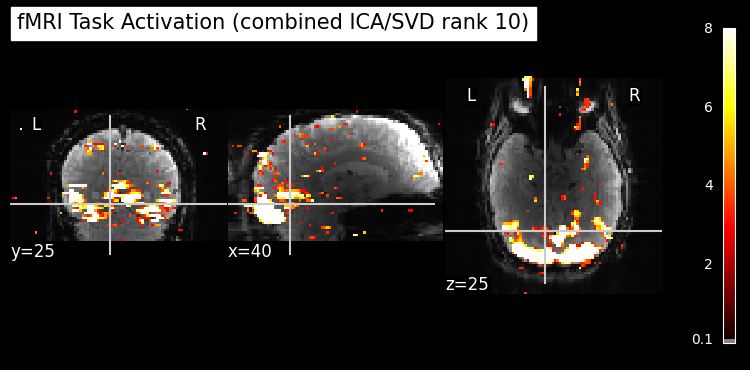

In [11]:

# DISPLAY ACTIVATION
# Initialize an empty array to hold the 3D data with shape (64, 88, 88)
slices_3d = np.zeros((num_slices_per_dim**2, slice_size, slice_size))
slice_index = 0
for i in range(num_slices_per_dim): # Loop to extract each 88x88 slice
    for j in range(num_slices_per_dim):
        # Extract each 88x88 slice
        slices_3d[slice_index, :, :] = np.squeeze(log10p_origsvd[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size])
        slice_index += 1
log10p_3dsvd = np.copy(slices_3d)
act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_3dsvd, (1, 2, 0)),3),axis=2), affine)

# Plot the anatomical image with the activation map overlay
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title=f'fMRI Task Activation (SVD rank {k})',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)

# Initialize an empty array to hold the 3D data with shape (64, 88, 88)
slices_3d = np.zeros((num_slices_per_dim**2, slice_size, slice_size))
slice_index = 0
for i in range(num_slices_per_dim): # Loop to extract each 88x88 slice
    for j in range(num_slices_per_dim):
        # Extract each 88x88 slice
        slices_3d[slice_index, :, :] = np.squeeze(log10p_origsvdica[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size])
        slice_index += 1
log10p_3dsvd = np.copy(slices_3d)
act_img = nib.Nifti1Image(np.flip(np.rot90(np.transpose(log10p_3dsvd, (1, 2, 0)),3),axis=2), affine)

# Plot the anatomical image with the activation map overlay
display = plotting.plot_stat_map(act_img, 
                                 bg_img=anat_img,
                                 threshold=.1, # threshold the activation map
                                 cmap='hot',        # Use 'hot' colormap for activation
                                 display_mode='ortho', # Choose display mode (ortho, x, y, or z)
                                 cut_coords=(40, 25, 25), # Adjust to control cut position
                                 title=f'fMRI Task Activation (combined ICA/SVD rank {k})',
                                 vmin = 0,
                                 vmax = 8,
                                 dim = -1, # brightness of background
                                 black_bg=True)





{'85% Variance Threshold': 5,
 '95% Variance Threshold': 38,
 'Singular Value Magnitude (>= 10000)': 169}

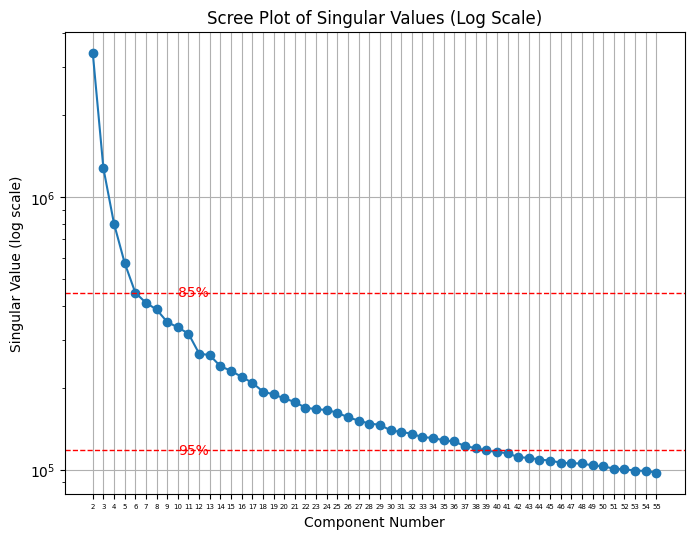

In [12]:
# scree plot of singular values of SVD for all ranks:
# have vector sigma:
#print(sigma.shape)
# Plotting the scree plot
Sigma2 = Sigma[1:]
num = 55

plt.figure(figsize=(8, 6))
plt.plot(range(2, num+1), Sigma2[:num-1], marker='o', linestyle='-', markersize=6)
plt.tick_params(axis='x', labelsize=5)

plt.yscale('log')  # Set y-axis to log scale (log base e)
plt.title("Scree Plot of Singular Values (Log Scale)")
plt.xlabel("Component Number")
plt.ylabel("Singular Value (log scale)")
plt.xticks(range(2, num+1))
plt.grid(True)
#plt.show()

# Calculate total variance (sum of squared singular values)
total_variance = np.sum(Sigma2 ** 2)

# Calculate explained variance for each component
explained_variance = Sigma2 ** 2 / total_variance

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Find the number of components for 85% and 95% variance threshold
num_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Singular Value Magnitude Threshold (Example: threshold at 10,000)
magnitude_threshold = 10000
num_components_magnitude = np.sum(Sigma2 >= magnitude_threshold)




y_intersect = Sigma2[num_components_85-1] #yline
plt.axhline(y=y_intersect, color='red', linestyle='--', linewidth=1)
plt.text(10, y_intersect, '85%', verticalalignment='center', color='red')  # Adjust x-value for position

y_intersect = Sigma2[num_components_95-1] #yline
plt.axhline(y=y_intersect, color='red', linestyle='--', linewidth=1)
plt.text(10, y_intersect, '95%', verticalalignment='center', color='red')  # Adjust x-value for position

# Display results
methods_results = {
    "85% Variance Threshold": num_components_85,
    "95% Variance Threshold": num_components_95,
    "Singular Value Magnitude (>= 10000)": num_components_magnitude
}

methods_results
